In [1]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import truvari
from sklearn.metrics import roc_curve, roc_auc_score


In [2]:
data = joblib.load("../stats/benchsummary.jl")
data['Merge'] = data['merge'].apply(lambda x: x[0].upper() + x[1:])
data["ref (prog)"] = data["reference"].map({'chm13': 'chm13 (B)', 
                            'sv': 'grch38 (M)', 
                            'hg19': 'hg19 (B)',
                            'grch38': 'grch38 (B)'})
data['Merge'] = data['Merge'].where(data['Merge'] != 'Survivor', "SURVIVOR")

In [3]:
metadata = pd.read_csv("../metadata/sample_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [13]:
data.groupby(['sample'])["call cnt"].mean().mean(), data.groupby(['sample'])["call cnt"].mean().std() 

(11659.386363636364, 1294.185308470082)

In [5]:
data.to_csv("short_read_discovery.txt", sep='\t')

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_90645/3642446992.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])


[Text(0.5, 1.0, 'Short-Read Recall of Merge pVCF SVs'),
 Text(0.5, 0, 'Reference (SV Caller)'),
 Text(0, 0.5, 'TP calls (thousands)')]

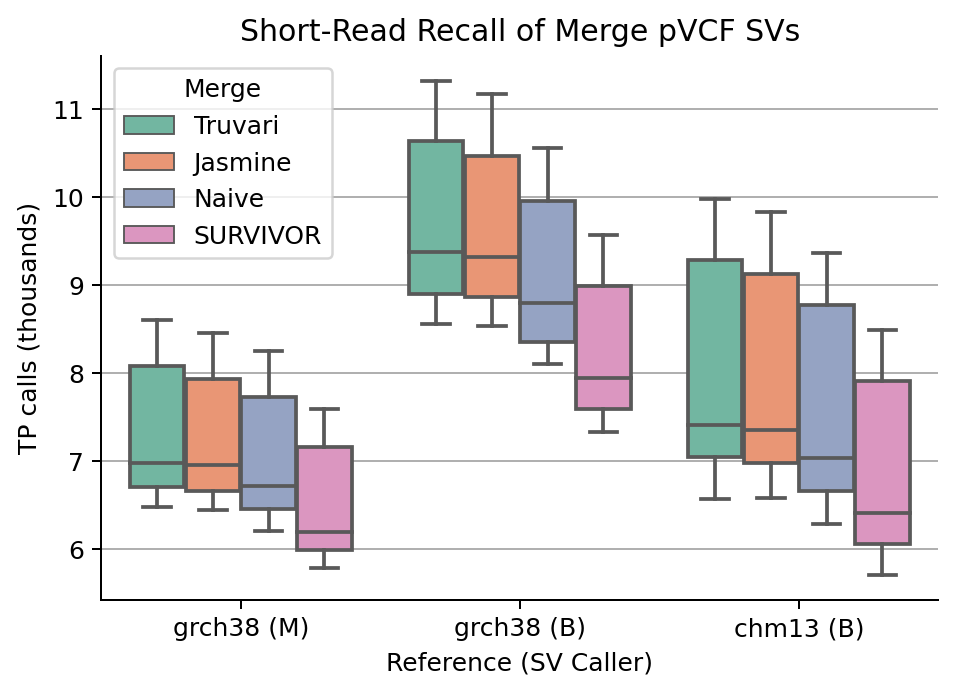

In [120]:
plt.figure(dpi=180)
p = sb.boxplot(data=data, 
               x='ref (prog)', 
               y="TP-call", 
               hue='Merge',
               order=['grch38 (M)', 'grch38 (B)', 'chm13 (B)'],
               hue_order=["Truvari", "Jasmine", "Naive", "SURVIVOR"],
              palette='Set2')
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)
#print(p.get_yticks())
p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])
p.set(title="Short-Read Recall of Merge pVCF SVs", xlabel="Reference (SV Caller)", ylabel="TP calls (thousands)")

[Text(0.5, 0, 'Reference (SV Caller)')]

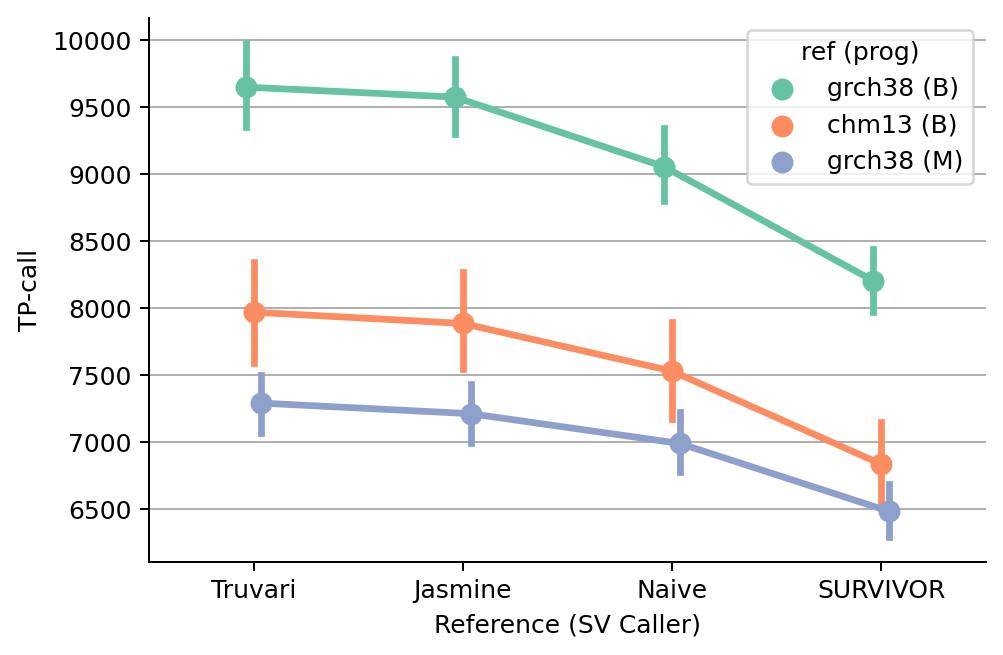

In [122]:
plt.figure(dpi=180)
p = sb.pointplot(data=data, 
               hue='ref (prog)', 
               y="TP-call", 
               x='Merge',
               hue_order=['grch38 (B)', 'chm13 (B)', 'grch38 (M)'],
               order=["Truvari", "Jasmine", "Naive", "SURVIVOR"],
              palette='Set2', dodge=True)
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)

p.set(xlabel="Reference (SV Caller)")

In [57]:
len(data['sample'].unique())

33

In [99]:
data.groupby(['ref (prog)', 'Merge'])["TP-call"].mean().unstack().round().astype(int)[["Truvari", "Jasmine", "Naive", "Survivor"]].mean()

Merge
Truvari     8584.25
Jasmine     8506.75
Naive       8103.75
Survivor    7388.00
dtype: float64

In [97]:
print(data.groupby(['ref (prog)'])["recall"].mean())
print(data.groupby(['ref (prog)'])["recall"].std())


ref (prog)
chm13 (B)     0.330979
grch38 (B)    0.374348
grch38 (M)    0.287408
hg19 (B)      0.372486
Name: recall, dtype: float64
ref (prog)
chm13 (B)     0.016306
grch38 (B)    0.019773
grch38 (M)    0.018428
hg19 (B)      0.019597
Name: recall, dtype: float64


In [73]:
data.groupby(['ref (prog)', 'Merge'])["precision"].mean().unstack().round(2)[["Truvari", "Jasmine", "Naive", "Survivor"]]

Merge,Truvari,Jasmine,Naive,Survivor
ref (prog),,,,
chm13 (B),0.72,0.71,0.68,0.62
grch38 (B),0.71,0.71,0.67,0.61
grch38 (M),0.84,0.83,0.80,0.74
hg19 (B),0.71,0.70,0.67,0.61


In [83]:
data.groupby(['ref (prog)', 'Merge'])["f1"].mean().unstack().round(2)[["Truvari", "Jasmine", "Naive", "Survivor"]]


Merge,Truvari,Jasmine,Naive,Survivor
ref (prog),,,,
chm13 (B),0.45,0.44,0.45,0.44
grch38 (B),0.49,0.48,0.49,0.47
grch38 (M),0.42,0.41,0.43,0.43
hg19 (B),0.48,0.47,0.49,0.47


In [92]:
data[data['ref (prog)'] == 'grch38 (B)']['f1'].mean(), data[data['ref (prog)'] == 'grch38 (B)']['f1'].std()

(0.48043467571185633, 0.012427238996640732)

In [93]:
data[data['ref (prog)'].str.endswith("M)")]['f1'].mean(), data[data['ref (prog)'].str.endswith("M)")]['f1'].std()

(0.4225156630295705, 0.016261576433467224)

# different merges long-read/short-read shared percents

In [32]:
columns = ["lr-pVCF", 'sr-pVCF', 'lr-unique', 'shared', 'sr-unique', 'sr-caller'] # average over samples
test = [['T', 'T', 100, 50, 20, 'B'],
        ['T', 'S', 120, 30, 10, 'B'],
        ['T', 'U', 120, 30, 10, 'B'],
        ['S', 'T', 120, 30, 10, 'B'],
        ['S', 'S', 120, 30, 10, 'B'],
        ['S', 'U', 120, 30, 10, 'B'],
        ['U', 'T', 120, 30, 10, 'B'],
        ['U', 'S', 120, 30, 10, 'B'],
        ['U', 'U', 120, 30, 10, 'B'],]
test = pd.DataFrame(test, columns=columns)
#sb.barplot(data=test, y=)
test = test.melt(id_vars = ['lr-pVCF', 'sr-pVCF', 'sr-caller'], value_vars=['lr-unique', 'shared', 'sr-unique'])
test['group'] = test["lr-pVCF"] + test['sr-pVCF']

In [52]:
test[test["variable"] == 'shared']["group"].apply(lambda x: x[0])

9     T
10    T
11    T
12    S
13    S
14    S
15    U
16    U
17    U
Name: group, dtype: object

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_3628/1032276651.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(test[test["variable"] == 'shared']["group"].apply(lambda x: x[1]))


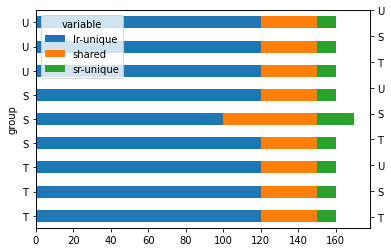

In [57]:
# Something like this. But 
import numpy as np
p = test.groupby(['group', 'variable'])['value'].sum() \
   .unstack('variable').plot.barh(stacked=True)
p.set_yticklabels(test[test["variable"] == 'shared']["group"].apply(lambda x: x[0]))
ax2 = p.twinx() 
ax2.set_yticklabels(test[test["variable"] == 'shared']["group"].apply(lambda x: x[1]))
ax2.set_yticks(np.linspace(ax2.get_yticks()[0] + 0.05, ax2.get_yticks()[-1], len(p.get_yticks())))

#print(len(p.get_yticklabels()), len(test["lr-pVCF"].values))


/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_3628/2584077517.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])
/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_3628/2584077517.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  hide = p.set_xticklabels(["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"])


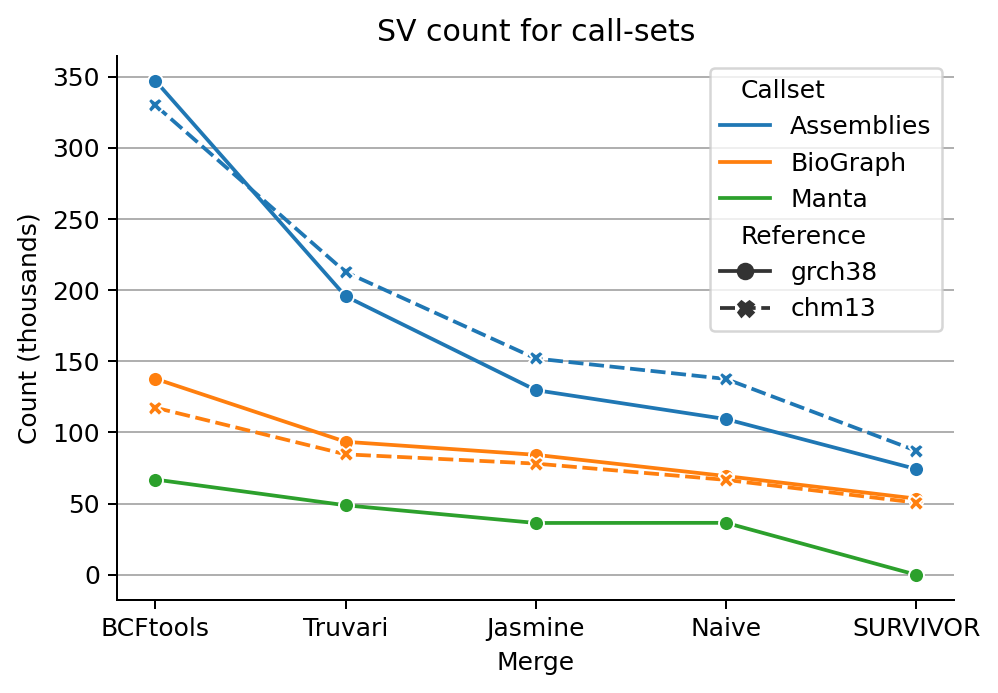

In [102]:
counts = pd.read_csv("../stats/pVCFcounts.csv")
plt.figure(dpi=180)
parts = []
for i in ["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"]:
    parts.append(counts[counts["Merge"] == i])
counts = pd.concat(parts)
p = sb.lineplot(data=counts, 
                x="Merge", sort=False,#order=["exact", "truvari", "jasmine", "naive", "survivor"],
                y="Count", 
                hue="Callset", hue_order=["Assemblies", "BioGraph", "Manta"],
                style='Reference', markers=True)
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)
p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])
p.set(title="SV count for call-sets", ylabel="Count (thousands)", xlabel="Merge")
hide = p.set_xticklabels(["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"])

In [96]:
counts

,Reference,Callset,Merge,Count,svtype
0,chm13,Assemblies,BCFtools,121068,DEL
1,chm13,Assemblies,BCFtools,208899,INS
10,grch38,assemblies,BCFtools,80365,DEL
11,grch38,assemblies,BCFtools,266836,INS
20,grch38,BioGraph,BCFtools,54529,DEL
21,grch38,BioGraph,BCFtools,83234INS,NaN
6,chm13,assemblies,Truvari,93025,DEL
7,chm13,assemblies,Truvari,119674,INS
16,grch38,assemblies,Truvari,63455,DEL
17,grch38,assemblies,Truvari,132287,INS


/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_3628/1965376797.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])
/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_3628/1965376797.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  hide = p.set_xticklabels(["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"])


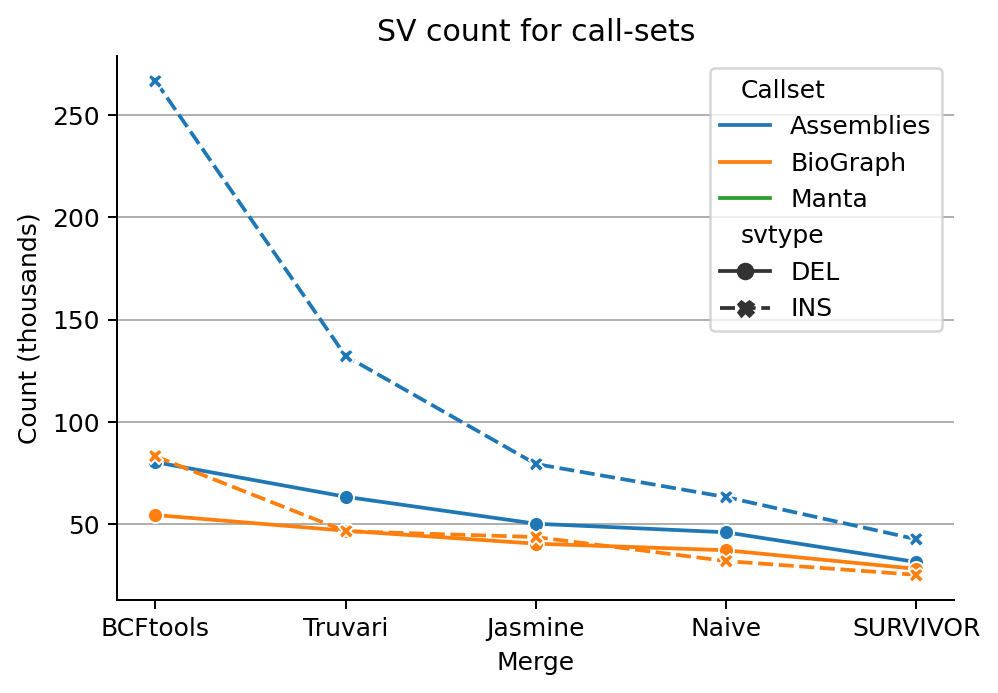

In [101]:
counts = pd.read_csv("../stats/pVCFcounts_bytype.csv")
plt.figure(dpi=180)
parts = []
for i in ["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"]:
    parts.append(counts[counts["Merge"] == i])
counts = pd.concat(parts)
p = sb.lineplot(data=counts[counts['Reference'] == 'grch38'], 
                x="Merge", sort=False,#order=["exact", "truvari", "jasmine", "naive", "survivor"],
                y="Count", 
                hue="Callset", hue_order=["Assemblies", "BioGraph", "Manta"],
                style='svtype', markers=True)
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)
p.set_yticklabels(["%d" % (x // 1000) for x in p.get_yticks()])
p.set(title="SV count for call-sets", ylabel="Count (thousands)", xlabel="Merge")
hide = p.set_xticklabels(["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"])

In [16]:
def acc(grp):
    view = grp["state"].value_counts()
    fp = view["fp"] if "fp" in view else 0
    tp = view["tp"] if "tp" in view else 0
    fn = view["fn"] if "fn" in view else 0
    tpbase = view["tpbase"] if "tpbase" in view else 0
    if tp + fp != 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
    if tpbase + fn != 0:
        recall = tpbase / (tpbase + fn)
    else:
        recall = 0
    neum = recall * precision
    denom = recall + precision
    if denom != 0:
        f1 = 2 * (neum / denom)
    else:
        f1 = None
    return precision, recall, f1

summary = []
for samp, dat in data.groupby(["sample", "reference", "program"]):
    summary.append([*samp, metadata.loc[samp[0]]["Superpopulation code"], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Reference", "Program", 
                                         "Superpopulation", "Precision", "Recall", "F1"])

In [17]:
grab = (summary["Program"] == "biograph") & (summary["F1"] > 0.550)
grab = grab | (summary["Program"] == "biograph") & (summary["Reference"] == "chm13") & (summary["F1"] > 0.52)
grab = grab | (summary["Program"] == "manta") & (summary["F1"] > 0.475)
grab = grab | (summary["Precision"] < 0.750)
grab = grab | ((summary["Program"] == "biograph") & (summary["Precision"] > 0.831) & (summary["Reference"] == "hg19"))
summary[grab]

,Sample,Reference,Program,Superpopulation,Precision,Recall,F1
1,HG00096,grch38,biograph,EUR,0.748320,0.366216,0.491768
3,HG00096,hg19,biograph,EUR,0.746677,0.362149,0.487738
8,HG00512,chm13,biograph,EAS,0.738625,0.346875,0.472060
9,HG00512,grch38,biograph,EAS,0.730640,0.383428,0.502928
11,HG00512,hg19,biograph,EAS,0.728285,0.379086,0.498627
...,...,...,...,...,...,...,...
113,NA19240,grch38,biograph,AFR,0.733982,0.366045,0.488479
115,NA19240,hg19,biograph,AFR,0.732239,0.366481,0.488481
125,NA20509,grch38,biograph,EUR,0.742807,0.365953,0.490336
127,NA20509,hg19,biograph,EUR,0.742544,0.365098,0.489511


# Performance Summary

In [18]:
summary.groupby(["Program"]).mean().applymap('{:.3f}'.format).T

Program,biograph,manta
Precision,0.742,0.876
Recall,0.354,0.278
F1,0.479,0.421


In [13]:
summary.groupby(["Program", "Reference"]).mean().applymap('{:.3f}'.format).T

Program   biograph                manta
Reference    chm13 grch38   hg19 grch38
Precision    0.744  0.741  0.739  0.876
Recall       0.329  0.368  0.366  0.278
F1           0.456  0.491  0.489  0.422

In [19]:
summary = []
for samp, dat in data.groupby(["sample", "svtype", "program", "reference"]):
    summary.append([samp[0], samp[2], samp[3], metadata.loc[samp[0]]["Superpopulation code"], samp[1], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Program", "Reference", "Superpopulation", "svtype", "Precision", "Recall", "F1"])

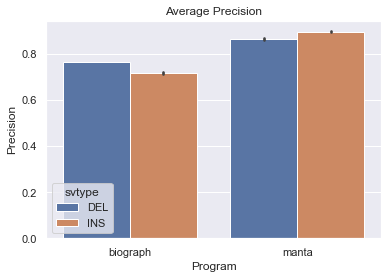

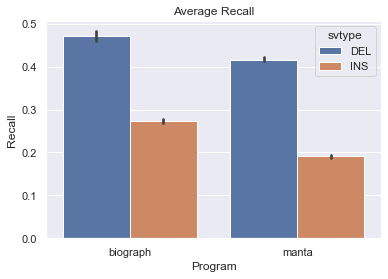

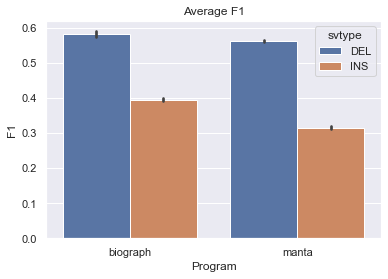

In [20]:
for i in ["Precision", "Recall", "F1"]:
    p = sb.barplot(data=summary, 
                   x="Program", 
                   y=i,
                  hue="svtype",
                  hue_order=["DEL", "INS"])
    p.set(title="Average " + i)
    plt.show()

# Performance by SZBIN/SVTYPE

In [26]:
summary = []
for samp, dat in data.groupby(["sample", "svtype", "szbin", "reference", "program"]):
    summary.append([samp[0], metadata.loc[samp[0]]["Superpopulation code"], samp[1], samp[2], samp[3], samp[4], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Superpopulation", "svtype", "szbin", "Reference", "Program", "Precision", "Recall", "F1"])
summary["szbin"] = summary["szbin"].astype(truvari.SZBINTYPE)

In [83]:
x = summary.groupby(["Program", "szbin", "svtype"]).mean()#.applymap('{:.3f}'.format)
(x.loc["biograph"] - x.loc["manta"]) \
    .style.apply(lambda x: ["color: teal" if v < 0 else "color: brown" for v in x], axis = 1) \
    .applymap('{:.3f}'.format)

In [49]:
def size_stat_summary(m_data, y_var):
    p = sb.catplot(data=m_data, 
                x="szbin", 
                y="Precision", 
                hue="svtype", 
                order=truvari.SZBINS[1:],
                kind="bar",
                col="Program")
    p.fig.subplots_adjust(top=0.8) 
    hide = p.fig.suptitle(f"Average {y_var} across samples by SVTYPE/Program")
    for axes in p.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
    plt.show()

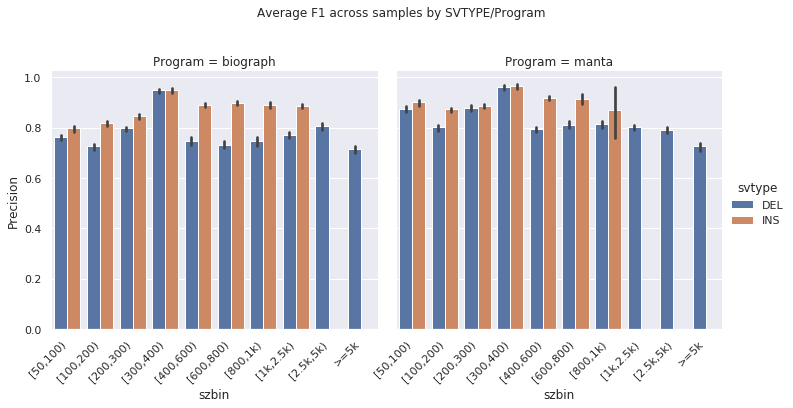

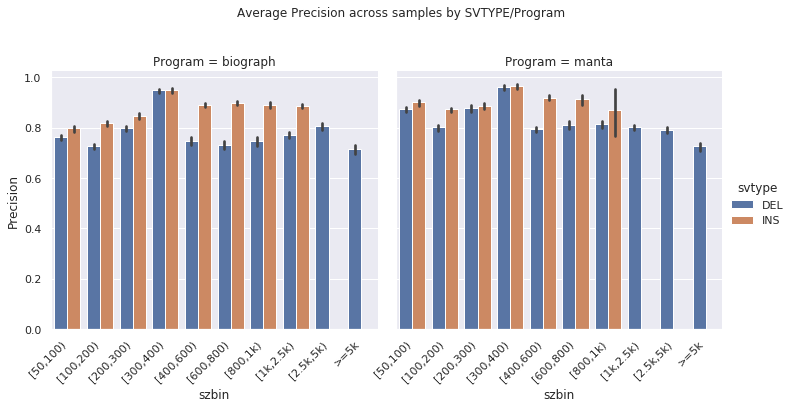

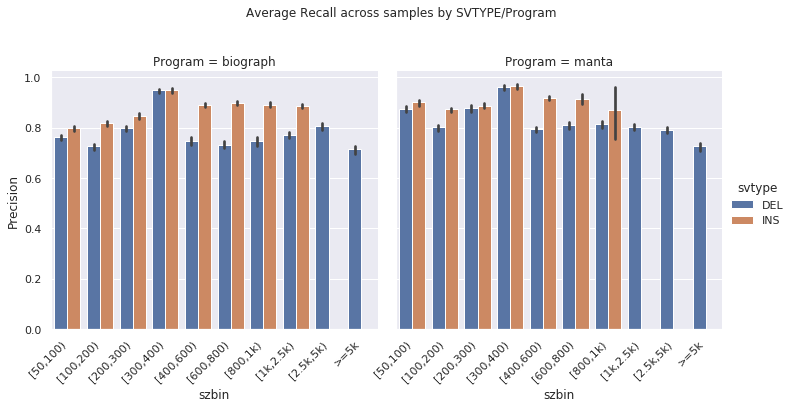

In [84]:
ref_grab = summary["Reference"] == "grch38"
size_stat_summary(summary[ref_grab], "F1")
size_stat_summary(summary[ref_grab], "Precision")
size_stat_summary(summary[ref_grab], "Recall")

# QUAL ROC 

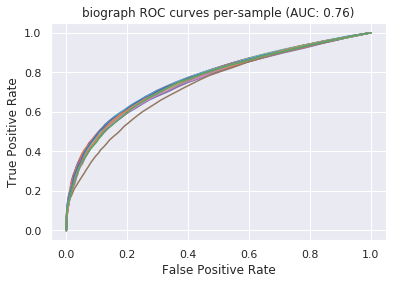

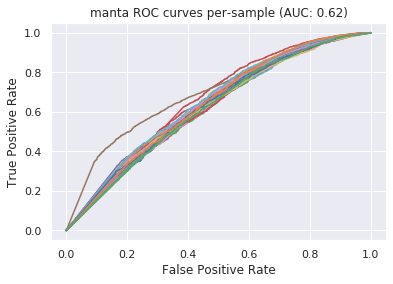

In [48]:
for prog, d1 in data.groupby("program"):
    m_auc = []
    for samp, dat in d1.groupby("sample"):
        view = dat[dat["state"].isin(["tp", "fp"])]
        #view.loc[view["state"] == "fn", "qual"] = -1
        fpr, tpr, thresholds = roc_curve(view["state"] == "tp", view["qual"])
        auc = roc_auc_score(view["state"] == "tp", view["qual"])
        plt.plot(fpr, tpr, label="%s (%.2f)" % (samp, auc))
        m_auc.append(auc)
    m_auc = pd.Series(auc).mean()
    plt.title(f"{prog} ROC curves per-sample (AUC: {m_auc:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

# Extra

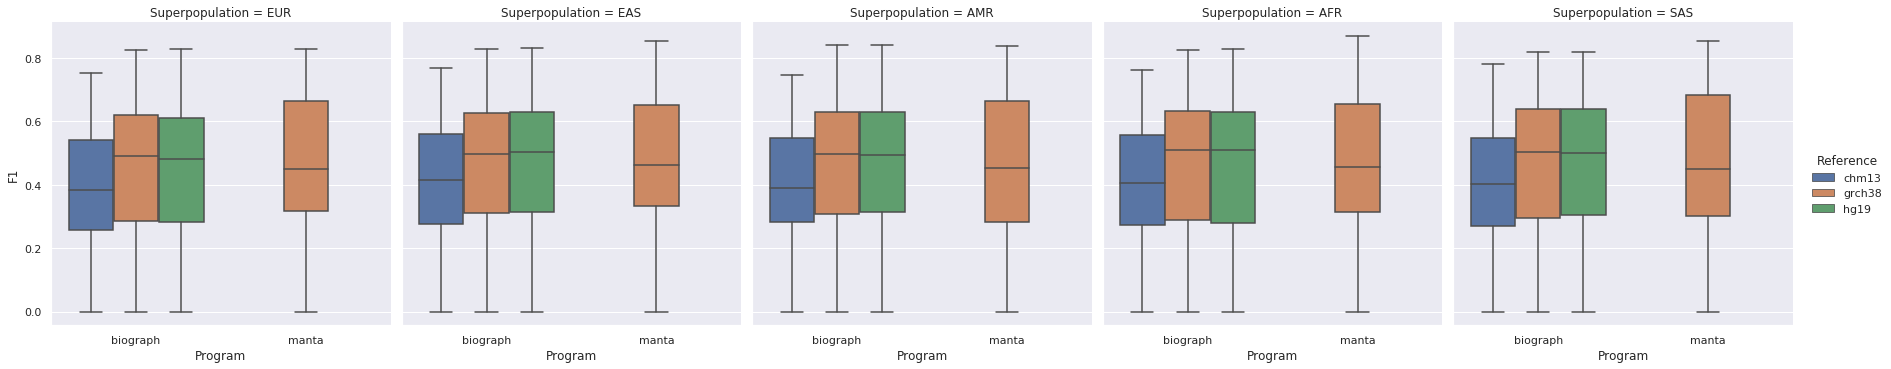

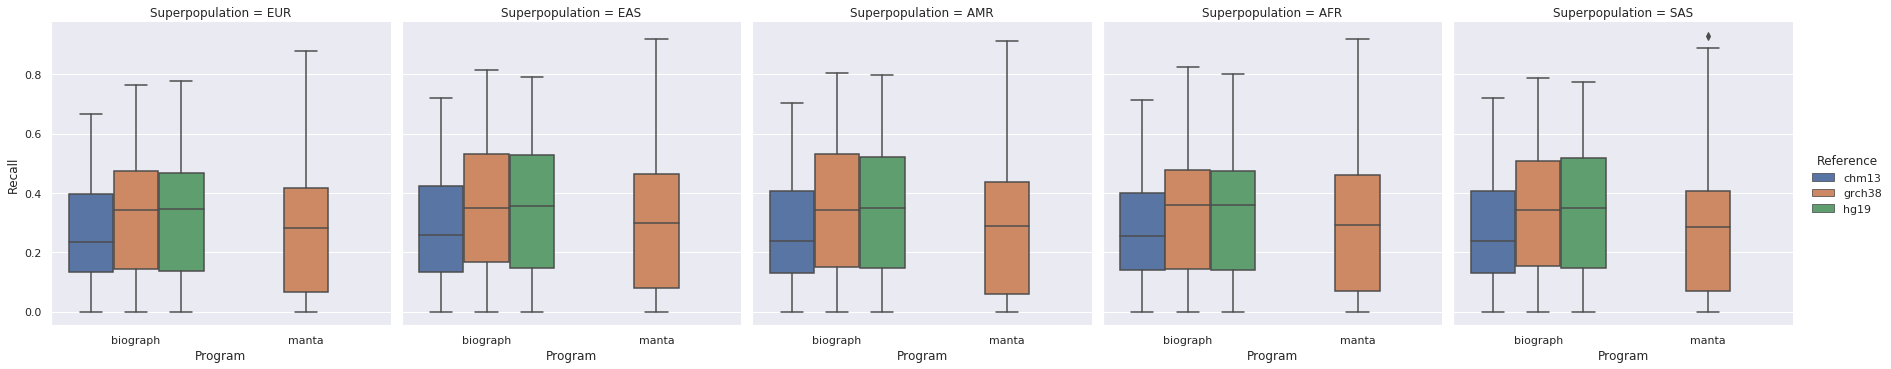

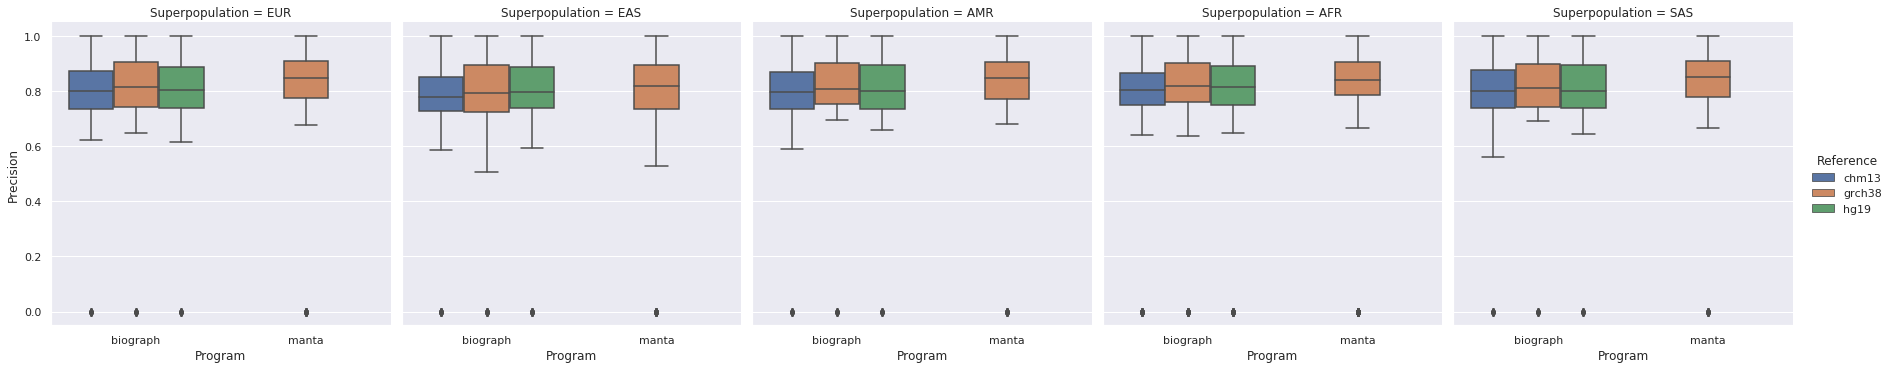

In [51]:
for y in ["F1", "Recall", "Precision"]:
    sb.catplot(data=summary,#[~grab], 
           x="Program", 
           y=y, 
           hue="Reference", 
           col="Superpopulation",
           kind="box")

In [85]:
s = pd.Series([0.3013107737577744,
 0.2859794788713379,
 0.2831705690865592,
 0.29108810049227635,
 0.2748468682078641,
 0.27638343931808956,
 0.2879510134480487,
 0.2929617720614505,
 0.267629533167594,
 0.2884837766138358,
 0.28915420485608617,
 0.2832516210659497,
 0.2790863668807994,
 0.2745111422038699,
 0.2884255000170364,
 0.27048003414955957,
 0.298952050409408,
 0.272737964560138,
 0.2780624310263282,
 0.2901273633415078,
 0.3373815980819872,
 0.2701071853910282,
 0.268208778173191,
 0.2839821314613912,
 0.2828497950654987,
 0.28877256035627785,

 0.2743823146944083,])

In [86]:
s.describe()

count    27.000000
mean      0.284455
std       0.013937
min       0.267630
25%       0.274679
50%       0.283252
75%       0.288963
max       0.337382
dtype: float64